<a href="https://colab.research.google.com/github/pstanisl/mlprague-2021/blob/main/CMAB-movielens_linucb_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tf-agents -q

In [2]:
!rm -f ./utils.py
!wget --no-check-certificate --no-cache --no-cookies \
    https://raw.githubusercontent.com/pstanisl/mlprague-2021/main/utils.py \
    -O ./utils.py

!rm -f ./lin_bandit_agent.py
!wget --no-check-certificate --no-cache --no-cookies \
    https://raw.githubusercontent.com/pstanisl/mlprague-2021/main/lin_bandit_agent.py \
    -O ./lin_bandit_agent.py

--2021-02-18 12:01:48--  https://raw.githubusercontent.com/pstanisl/mlprague-2021/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3657 (3.6K) [text/plain]
Saving to: ‘./utils.py’

./utils.py          100%[===================>]   3.57K  --.-KB/s    in 0s      

2021-02-18 12:01:48 (9.16 MB/s) - ‘./utils.py’ saved [3657/3657]

--2021-02-18 12:01:48--  https://raw.githubusercontent.com/pstanisl/mlprague-2021/main/lin_bandit_agent.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16931 (17K) [text/plain]
Saving to: ‘./l

In [3]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf  # pylint: disable=g-explicit-tensorflow-version-import
import tensorflow_probability as tfp
import zipfile

from tqdm.notebook import trange
from typing import Optional, Sequence, Text, Tuple

from tf_agents.bandits.agents import linear_bandit_agent as lin_agent
from tf_agents.bandits.environments import environment_utilities
from tf_agents.bandits.environments import bandit_py_environment
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.bandits.policies import linalg
from tf_agents.bandits.policies import linear_bandit_policy
from tf_agents.bandits.policies import policy_utilities
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import tf_py_environment
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.specs import array_spec
from tf_agents.trajectories import policy_step
from tf_agents.trajectories import time_step as ts
from tf_agents.typing import types

from lin_bandit_agent import LinearBanditAgent
from utils import load_movielens_data, plot_regret

In [4]:
print("Downloading movielens data...")

!wget --no-check-certificate \
    http://files.grouplens.org/datasets/movielens/ml-100k.zip \
    -O ./movielens.zip

zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()

print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info').decode())

--2021-02-18 12:01:52--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘./movielens.zip’

./movielens.zip     100%[===================>]   4.70M  15.9MB/s    in 0.3s    

2021-02-18 12:01:52 (15.9 MB/s) - ‘./movielens.zip’ saved [4924029/4924029]

Done. Dataset contains:
943 users
1682 items
100000 ratings



In [5]:
RANK_K = 20 # @param {type:"integer"}
NUM_ACTIONS = 20 # @param {type:"integer"}

## Environment

In [6]:
class MovieLensPyEnvironment(bandit_py_environment.BanditPyEnvironment):
  """Implements the MovieLens Bandit environment.
  This environment implements the MovieLens 100K dataset, available at:
  https://www.kaggle.com/prajitdatta/movielens-100k-dataset
  This dataset contains 100K ratings from 943 users on 1682 items.
  This csv list of:
  user id | item id | rating | timestamp.
  This environment computes a low-rank matrix factorization (using SVD) of the
  data matrix A, such that: A ~= U * V.
  The reward of recommending item `j` to user `i` is provided as A_{ij}.
  """

  def __init__(self,
               data_dir: Text,
               rank_k: int,
               batch_size: int = 1,
               num_movies: int = 20,
               name: Optional[Text] = 'movielens'):
    """Initializes the MovieLens Bandit environment.
    Args:
      data_dir: (string) Directory where the data lies (in text form).
      rank_k : (int) Which rank to use in the matrix factorization.
      batch_size: (int) Number of observations generated per call.
      num_movies: (int) Only the first `num_movies` movies will be used by the
        environment. The rest is cut out from the data.
      name: The name of this environment instance.
    """
    self._num_actions = num_movies
    self._batch_size = batch_size
    self._context_dim = rank_k

    # Compute the matrix factorization.
    #self._data_matrix = dataset_utilities.load_movielens_data(data_dir)
    self._data_matrix = load_movielens_data(data_dir)
    # Keep only the first items.
    self._data_matrix = self._data_matrix[:, :num_movies]
    # Filter the users with no iterm rated.
    nonzero_users = list(np.nonzero(np.sum(self._data_matrix, axis=1) > 0.0)[0])
    self._data_matrix = self._data_matrix[nonzero_users, :]
    self._effective_num_users = len(nonzero_users)

    # Compute the SVD.
    u, s, vh = np.linalg.svd(self._data_matrix, full_matrices=False)

    # Keep only the largest singular values.
    self._u_hat = u[:, :rank_k] * np.sqrt(s[:rank_k])
    self._v_hat = np.transpose(
        np.transpose(vh[:rank_k, :]) * np.sqrt(s[:rank_k]))
    self._approx_ratings_matrix = np.matmul(self._u_hat, self._v_hat)

    self._current_users = np.zeros(batch_size, dtype=np.int32)
    self._previous_users = np.zeros(batch_size, dtype=np.int32)

    self._action_spec = array_spec.BoundedArraySpec(
        shape=(),
        dtype=np.int32,
        minimum=0,
        maximum=self._num_actions - 1,
        name='action')
    observation_spec = array_spec.ArraySpec(
        shape=(self._context_dim,), dtype=np.float64, name='observation')
    self._time_step_spec = ts.time_step_spec(observation_spec)
    self._observation = np.zeros((self._batch_size, self._context_dim))

    self._optimal_action_table = np.argmax(
        self._approx_ratings_matrix, axis=1)
    self._optimal_reward_table = np.max(
        self._approx_ratings_matrix, axis=1)

    super(MovieLensPyEnvironment, self).__init__(
        observation_spec, self._action_spec)

  @property
  def batch_size(self):
    return self._batch_size

  @property
  def batched(self):
    return True

  def _observe(self):
    """Returns the u vectors of a random sample of users."""
    sampled_users = random.sample(
        range(self._effective_num_users), self._batch_size)
    self._previous_users = self._current_users
    self._current_users = sampled_users
    batched_observations = self._u_hat[sampled_users]
    return batched_observations

  def _apply_action(self, action):
    """Computes the reward for the input actions."""
    rewards = []
    for i, j in zip(self._current_users, action):
      rewards.append(self._approx_ratings_matrix[i, j])
    return np.array(rewards)

  def compute_optimal_action(self):
    return self._optimal_action_table[self._previous_users]

  def compute_optimal_reward(self):
    return self._optimal_reward_table[self._previous_users]

In [7]:
env = MovieLensPyEnvironment('./ml-100k/u.data', RANK_K, 8, num_movies=NUM_ACTIONS)
tf_env = tf_py_environment.TFPyEnvironment(env)

In [8]:
print('Observation spec:', tf_env.observation_spec())
print('An observation: ', tf_env.reset().observation.numpy())

action = tf.zeros(8, dtype=tf.int32)
time_step = tf_env.step(action)

print()
print(f'Action={action.numpy()} (optimal={tf_env.compute_optimal_action()})')
print(f'Reward={time_step.reward.numpy()} (optimal={tf_env.compute_optimal_reward()})')

Observation spec: TensorSpec(shape=(20,), dtype=tf.float64, name='observation')
An observation:  [[-4.76874249e-01 -2.24032857e-02  6.30213577e-01 -2.63696813e-01
  -2.75222237e-01 -1.23646786e-01  8.03087926e-02  5.52227644e-01
  -2.35701748e-01  3.91127308e-01  1.66290313e-01  1.12844673e-01
   2.20605621e-01  3.01339275e-02  1.38195140e-02 -4.34948098e-02
   1.50221207e-04  3.38270337e-03  6.29632815e-02  1.38815806e-02]
 [-1.62041788e-01  3.93971060e-01  2.32109780e-01  1.80687459e-01
  -6.35209853e-02  4.72865609e-01 -6.33220380e-04 -4.23756055e-02
  -3.80948069e-01  3.10127611e-01  1.10609854e-01  7.80734281e-02
   2.09127987e-01  3.05486810e-02  7.87156093e-02  8.05282555e-03
  -2.49590664e-02  1.93493710e-03  4.50853499e-02  2.69688588e-02]
 [-5.58660717e-01  5.83705444e-01  2.02208228e-01 -2.56263282e-01
  -2.78763972e-01  3.37644116e-03 -9.32370372e-02 -4.94498106e-02
   2.28888583e-01 -9.34893496e-03  3.39774595e-01  1.45811889e-02
   2.91392528e-01 -8.30450361e-02  4.895658

## Policy

In [9]:
class LinearUCBPolicy(linear_bandit_policy.LinearBanditPolicy):
  """LinearUCB policy is simplified version of LinearBanditPolicy from tf_agente."""

  def __init__(self,
               action_spec: types.BoundedTensorSpec,
               variable_collection: tf.Module,
               time_step_spec: Optional[types.TimeStep] = None,
               alpha: float = 1.0,
               tikhonov_weight: float = 1.0,
               name: Optional[Text] = None):
    super(LinearUCBPolicy, self).__init__(
        action_spec,
        cov_matrix=variable_collection.cov_matrix_list,
        data_vector=variable_collection.data_vector_list,
        num_samples=variable_collection.num_samples_list,
        time_step_spec=time_step_spec,
        alpha=alpha,
        tikhonov_weight=tikhonov_weight,
        name=name)

  def _distribution(self, time_step, policy_state):
    observation = tf.nest.map_structure(lambda o: tf.cast(o, dtype=self._dtype),
                                        time_step.observation)
    
    current_observation = tf.reshape(
        observation, [-1, self._global_context_dim])

    est_rewards = []
    confidence_intervals = []

    for model_index in range(self._num_actions):
      # Compute confidence interval for action(i): x^T*A^-1*x
      # 1: A^-1*x -> A^-1x
      a_inv_x = linalg.conjugate_gradient_solve(
          self._cov_matrix[model_index] + self._tikhonov_weight *
          tf.eye(self._overall_context_dim, dtype=self._dtype),
          tf.linalg.matrix_transpose(current_observation))
      # 2: x^T*A^-1x -> confidence interval of action(i)
      ci = tf.reshape(
          tf.linalg.tensor_diag_part(tf.matmul(current_observation, a_inv_x)),
          [-1, 1])
      
      confidence_intervals.append(ci)
      est_mean_reward = tf.einsum('j,jk->k', self._data_vector[model_index],
                                  a_inv_x)
      est_rewards.append(est_mean_reward)
    # Estimate rewards for every action
    optimistic_estimates = [
        tf.reshape(mean_reward, [-1, 1]) + self._alpha * tf.sqrt(confidence)
        for mean_reward, confidence in zip(est_rewards, confidence_intervals)
    ]
    # Keeping the batch dimension during the squeeze, even if batch_size == 1.
    rewards_for_argmax = tf.squeeze(
        tf.stack(optimistic_estimates, axis=-1), axis=[1])
    # Choose the best action for every observation in the batch
    chosen_actions = tf.argmax(
        rewards_for_argmax,
        axis=-1,
        output_type=tf.nest.flatten(self._action_spec)[0].dtype)

    action_distributions = tfp.distributions.Deterministic(loc=chosen_actions)

    policy_info = policy_utilities.populate_policy_info(
        None, chosen_actions, rewards_for_argmax,
        tf.stack(est_rewards, axis=-1), self._emit_policy_info,
        False)

    return policy_step.PolicyStep(
        action_distributions, policy_state, policy_info)
    

In [10]:
class LinearTSPolicy(linear_bandit_policy.LinearBanditPolicy):
  """LinearTS policy is simplified version of LinearBanditPolicy from tf_agente."""

  def __init__(self,
               action_spec: types.BoundedTensorSpec,
               variable_collection: tf.Module,
               time_step_spec: Optional[types.TimeStep] = None,
               alpha: float = 1.0,
               tikhonov_weight: float = 1.0,
               name: Optional[Text] = None):
    super(LinearTSPolicy, self).__init__(
        action_spec,
        cov_matrix=variable_collection.cov_matrix_list,
        data_vector=variable_collection.data_vector_list,
        num_samples=variable_collection.num_samples_list,
        time_step_spec=time_step_spec,
        alpha=alpha,
        tikhonov_weight=tikhonov_weight,
        name=name)

  def _distribution(self, time_step, policy_state):
    observation = tf.nest.map_structure(lambda o: tf.cast(o, dtype=self._dtype),
                                        time_step.observation)
    
    current_observation = tf.reshape(
        observation, [-1, self._global_context_dim])

    est_rewards = []
    confidence_intervals = []

    for model_index in range(self._num_actions):
      # Compute confidence interval for action(i): x^T*A^-1*x
      # 1: A^-1*x -> A^-1x
      a_inv_x = linalg.conjugate_gradient_solve(
          self._cov_matrix[model_index] + self._tikhonov_weight *
          tf.eye(self._overall_context_dim, dtype=self._dtype),
          tf.linalg.matrix_transpose(current_observation))
      # 2: x^T*A^-1x -> confidence interval of action(i)
      ci = tf.reshape(
          tf.linalg.tensor_diag_part(tf.matmul(current_observation, a_inv_x)),
          [-1, 1])
      
      confidence_intervals.append(ci)
      est_mean_reward = tf.einsum('j,jk->k', self._data_vector[model_index],
                                  a_inv_x)
      est_rewards.append(est_mean_reward)
    # Sample from the Normapl distribution
    mu_sampler = tfp.distributions.Normal(
          loc=tf.stack(est_rewards, axis=-1),
          scale=self._alpha *
          tf.sqrt(tf.squeeze(tf.stack(confidence_intervals, axis=-1), axis=1)))
    rewards_for_argmax = mu_sampler.sample()
    # Choose the best action for every observation in the batch
    chosen_actions = tf.argmax(
        rewards_for_argmax,
        axis=-1,
        output_type=tf.nest.flatten(self._action_spec)[0].dtype)

    action_distributions = tfp.distributions.Deterministic(loc=chosen_actions)

    policy_info = policy_utilities.populate_policy_info(
        None, chosen_actions, rewards_for_argmax,
        tf.stack(est_rewards, axis=-1), self._emit_policy_info,
        False)

    return policy_step.PolicyStep(
        action_distributions, policy_state, policy_info)

## Agent

In [11]:
from tf_agents.agents import data_converter
from tf_agents.agents import tf_agent
from tf_agents.bandits.agents import utils as bandit_utils
from tf_agents.bandits.agents import linear_bandit_agent as lin_agent

In [12]:
def update_a_and_b_with_forgetting(
    a_prev: types.Tensor,
    b_prev: types.Tensor,
    r: types.Tensor,
    x: types.Tensor,
    gamma: float
) -> Tuple[types.Tensor, types.Tensor, types.Tensor, types.Tensor]:
  r"""Update the covariance matrix `a` and the weighted sum of rewards `b`.
  This function updates the covariance matrix `a` and the sum of weighted
  rewards `b` using a forgetting factor `gamma`.
  Args:
    a_prev: previous estimate of `a`.
    b_prev: previous estimate of `b`.
    r: a `Tensor` of shape [`batch_size`]. This is the rewards of the batched
      observations.
    x: a `Tensor` of shape [`batch_size`, `context_dim`]. This is the matrix
      with the (batched) observations.
    gamma: a float forgetting factor in [0.0, 1.0].
  Returns:
    The updated estimates of `a` and `b` and optionally the eigenvalues and
    eigenvectors of `a`.
  """
  a_new = gamma * a_prev + tf.matmul(x, x, transpose_a=True)
  b_new = gamma * b_prev + bandit_utils.sum_reward_weighted_observations(r, x)

  eig_vals = tf.constant([], dtype=a_new.dtype)
  eig_matrix = tf.constant([], dtype=a_new.dtype)
  
  return a_new, b_new, eig_vals, eig_matrix

In [13]:
class LinearUCBAgent(lin_agent.LinearBanditAgent):
    def __init__(self,
               time_step_spec: types.TimeStep,
               action_spec: types.BoundedTensorSpec,
               alpha: float = 1.0,
               tikhonov_weight: float = 1.0,
               dtype: tf.DType = tf.float32,
               name: Optional[Text] = None):

      super(LinearUCBAgent, self).__init__(
          lin_agent.ExplorationPolicy.linear_ucb_policy,
          time_step_spec=time_step_spec,
          action_spec=action_spec,
          alpha=alpha,
          tikhonov_weight=tikhonov_weight,
          dtype=dtype,
          name=name
      )

      self._as_trajectory = data_converter.AsTrajectory(
        self.data_context, sequence_length=None)

      policy = LinearTSPolicy(
          action_spec=action_spec,
          variable_collection=self._variable_collection,
          time_step_spec=time_step_spec,
          alpha=alpha,
          tikhonov_weight=tikhonov_weight
      )

      #self._policy = LinearUCBPolicy(
      #    action_spec=action_spec,
      #    variable_collection=self._variable_collection,
      #    time_step_spec=time_step_spec,
      #    alpha=alpha,
      #    tikhonov_weight=tikhonov_weight
      #)
    
    def _train(self, experience, weights=None):
      """Updates the policy based on the data in `experience`.
      Note that `experience` should only contain data points that this agent has
      not previously seen. If `experience` comes from a replay buffer, this buffer
      should be cleared between each call to `train`.
      Args:
        experience: A batch of experience data in the form of a `Trajectory`.
        weights: Unused.
      Returns:
          A `LossInfo` containing the loss *before* the training step is taken.
          In most cases, if `weights` is provided, the entries of this tuple will
          have been calculated with the weights.  Note that each Agent chooses
          its own method of applying weights.
      """
      experience = self._as_trajectory(experience)

      del weights  # unused

      reward, action, observation, batch_size = self._process_experience(
          experience)
      #print('action', action)
      
      for k in range(self._num_models):
        diag_mask = tf.linalg.tensor_diag(
            tf.cast(tf.equal(action, k), self._dtype))
        #print(f'{k} - diag_mas={diag_mask}')
        observations_for_arm = tf.matmul(diag_mask, observation)
        #print(f'{k} - observations_for_arm={observations_for_arm}')
        rewards_for_arm = tf.matmul(diag_mask, tf.reshape(reward, [-1, 1]))

        num_samples_for_arm_current = tf.reduce_sum(diag_mask)
        #print(f'{k} - num_samples_for_arm_current={num_samples_for_arm_current}')
        tf.compat.v1.assign_add(self._num_samples_list[k],
                                num_samples_for_arm_current)
        num_samples_for_arm_total = self._num_samples_list[k].read_value()

        # Update the matrix A and b.
        # pylint: disable=cell-var-from-loop,g-long-lambda
        def update(cov_matrix, data_vector):
          return update_a_and_b_with_forgetting(
              cov_matrix, 
              data_vector,           
              rewards_for_arm,      
              observations_for_arm, 
              self._gamma
          )
        # Compute updated matrixes (A, b, and eigenvectors)
        a_new, b_new, eig_vals, eig_matrix = tf.cond(
            tf.squeeze(num_samples_for_arm_total) > 0,
            lambda: update(self._cov_matrix_list[k], self._data_vector_list[k]),
            lambda: (self._cov_matrix_list[k], self._data_vector_list[k],
                    self._eig_vals_list[k], self._eig_matrix_list[k]))
        # Update real variables
        tf.compat.v1.assign(self._cov_matrix_list[k], a_new)
        tf.compat.v1.assign(self._data_vector_list[k], b_new)
        tf.compat.v1.assign(self._eig_vals_list[k], eig_vals)
        tf.compat.v1.assign(self._eig_matrix_list[k], eig_matrix)

      loss = -1. * tf.reduce_sum(reward)
      self.compute_summaries(loss)

      self._train_step_counter.assign_add(batch_size)

      return tf_agent.LossInfo(loss=(loss), extra=())


In [14]:
agent = LinearUCBAgent(
    time_step_spec=tf_env.time_step_spec(),
    action_spec=tf_env.action_spec(),
    tikhonov_weight=0.001,
    alpha=10.0,
    dtype=tf.float32
)

In [15]:
print('training data spec: ', agent.training_data_spec)

training data spec:  Trajectory(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), observation=TensorSpec(shape=(20,), dtype=tf.float64, name='observation'), action=BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(19, dtype=int32)), policy_info=PolicyInfo(log_probability=(), predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=()), next_step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)))


In [16]:
print('observation spec in training: ', agent.training_data_spec.observation)

observation spec in training:  TensorSpec(shape=(20,), dtype=tf.float64, name='observation')


## Experiment

In [17]:
def set_expected_shape(experience, num_steps):
  def set_time_dim(input_tensor, steps):
    tensor_shape = input_tensor.shape.as_list()
    tensor_shape[1] = steps
    input_tensor.set_shape(tensor_shape)
  tf.nest.map_structure(lambda t: set_time_dim(t, num_steps), experience)

In [18]:
def run(
    environment, 
    agent, 
    iterations, 
    steps_per_loop,
    additional_metrics=()
):
  replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
      data_spec=agent.policy.trajectory_spec,
      batch_size=environment.batch_size,
      max_length=steps_per_loop)
  
  metrics = [] + list(additional_metrics)
  ret_metrics = dict([(m.name, []) for m in metrics])

  observers = [replay_buffer.add_batch] + metrics

  driver = dynamic_step_driver.DynamicStepDriver(
      env=environment,
      policy=agent.collect_policy,
      num_steps=steps_per_loop * environment.batch_size,
      observers=observers)

  regret_values = []

  for _ in trange(num_iterations):
    driver.run()
    loss_info = agent.train(replay_buffer.gather_all())
    replay_buffer.clear()
    # Log metrics value
    for metric in metrics:
      ret_metrics[metric.name].append(metric.result())

  return ret_metrics

In [19]:
def get_metrics(environment):
  optimal_reward_fn = functools.partial(
        environment_utilities.compute_optimal_reward_with_movielens_environment,
        environment=tf_env)
  optimal_action_fn = functools.partial(
        environment_utilities.compute_optimal_action_with_movielens_environment,
        environment=tf_env)
  
  regret_metric = tf_bandit_metrics.RegretMetric(
      optimal_reward_fn, 
      name='regret'
  )
  suboptimal_arms_metric = tf_bandit_metrics.SuboptimalArmsMetric(
      optimal_action_fn,
      name='suboptimal_arms'
  )
  
  return [regret_metric, suboptimal_arms_metric]

In [25]:
batch_size =   8# @param {type:"integer"}
num_iterations =   150# @param {type:"integer"}
steps_per_loop =   8# @param {type:"integer"}
agent_alpha = 10.0  # @param {type: "number"}

env = MovieLensPyEnvironment(
    './ml-100k/u.data', 
    rank_k=RANK_K,
    batch_size=batch_size, 
    num_movies=NUM_ACTIONS
)
tf_env = tf_py_environment.TFPyEnvironment(env)
tf_env.reset()

agent = LinearUCBAgent(
    time_step_spec=tf_env.time_step_spec(),
    action_spec=tf_env.action_spec(),
    tikhonov_weight=0.001,
    alpha=agent_alpha,
    dtype=tf.float32
)

additional_metrics = get_metrics(tf_env)

metrics = run(
    tf_env, 
    agent, 
    iterations=num_iterations,
    steps_per_loop=steps_per_loop,
    additional_metrics=additional_metrics
)

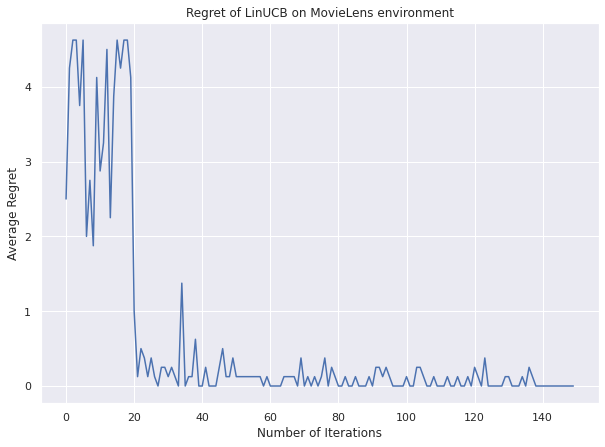

In [26]:
plot_regret(metrics['regret'], {'algorithm': 'LinUCB'})

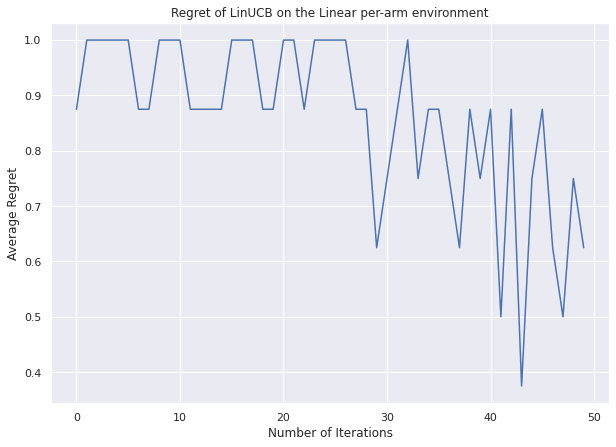

In [22]:
plt.figure(figsize=(10, 7))
plt.plot(metrics['suboptimal_arms'])
plt.title('Regret of LinUCB on the Linear per-arm environment')
plt.xlabel('Number of Iterations')
_ = plt.ylabel('Average Regret')